In [9]:
import polars as pl
import json
import requests
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Polish Baby Names

Exploring first names given to children in Poland over the last decade, using data from the [Polish Open Data API](https://api.dane.gov.pl/).

## API response schema

Each row in the raw DataFrame has these `attributes`:

| Field | Example | Description |
|---|---|---|
| `WOJEWÓDZTWO` | `"DOLNOŚLĄSKIE"` | Voivodeship (region) |
| `GMINIA` | `"BOLESŁAWIEC"` | Municipality |
| `KT_USC` | `"0201011"` | Registry office code |
| `PŁEĆ` | `"KOBIETA"` | Sex (`KOBIETA` = female, `MĘŻCZYZNA` = male) |
| `IMIE` | `"MAJA"` | First name |
| `POWIAT` | `"BOLESŁAWIECKI"` | County |
| `LICZBA WYSTĄPIEŃ` | `16` | Number of occurrences |

In [10]:
BASE_URL = "https://api.dane.gov.pl/1.4/resources"
DATA_DIR = "raw-data"
REPORTS_DIR = "reports"

# 2000-2019 consolidated dataset (has year, name, count, sex)
CONSOLIDATED_ID = 21458

# 2020-2025: separate male/female resources per year (national)
YEARLY_RESOURCES = {
    2020: {"M": 28020, "F": 28021},
    2021: {"M": 36393, "F": 36394},
    2022: {"M": 44825, "F": 44824},
    2023: {"M": 54099, "F": 54100},
    2024: {"M": 63900, "F": 63899},
    2025: {"M": 1159536, "F": 1159538},
}

# 2025 regional data (by voivodeship)
REGIONAL_RESOURCES = {
    2025: {"M": 1159541, "F": 1159548},
}


def fetch_all_pages(resource_id, per_page=100):
    """Fetch all pages from a dane.gov.pl resource."""
    rows = []
    url = f"{BASE_URL}/{resource_id}/data?per_page={per_page}"
    while url:
        r = requests.get(url)
        r.raise_for_status()
        resp = r.json()
        for row in resp.get("data", []):
            attrs = row.get("attributes", {})
            rows.append({k: v.get("repr") for k, v in attrs.items()})
        url = resp.get("links", {}).get("next")
    return rows

## Fetch data

Two sources:
- **2000–2019**: a single consolidated resource with `(year, name, count, sex)`.
- **2020–2025**: separate male/female resources per year with `(name, sex, count)`.

In [11]:
import os

os.makedirs(DATA_DIR, exist_ok=True)

COLS = ["year", "name", "sex", "count"]

# --- 2000-2019 consolidated ---
consolidated_path = f"{DATA_DIR}/data_2000_2019.csv"
if os.path.exists(consolidated_path):
    print(f"Loading cached {consolidated_path}")
    df_raw = pl.read_csv(consolidated_path)
    if "Rok" in df_raw.columns:
        df_historical = (
            df_raw
            .rename({"Rok": "year", "Imię": "name", "Liczba": "count", "Płeć": "sex"})
            .with_columns(
                pl.col("year").cast(pl.Int32),
                pl.col("count").cast(pl.Int64),
                pl.when(pl.col("sex") == "M")
                .then(pl.lit("MALE"))
                .otherwise(pl.lit("FEMALE"))
                .alias("sex"),
            )
        )
    else:
        df_historical = df_raw
else:
    print("Fetching 2000-2019 consolidated data...")
    rows_consolidated = fetch_all_pages(CONSOLIDATED_ID)
    df_historical = (
        pl.DataFrame(rows_consolidated)
        .rename({"col1": "year", "col2": "name", "col3": "count", "col4": "sex"})
        .with_columns(
            pl.col("year").cast(pl.Int32),
            pl.col("count").cast(pl.Int64),
            pl.when(pl.col("sex") == "M")
            .then(pl.lit("MALE"))
            .otherwise(pl.lit("FEMALE"))
            .alias("sex"),
        )
    )
    df_historical.write_csv(consolidated_path)
    print(f"  {len(df_historical)} rows → {consolidated_path}")

print(f"  {len(df_historical)} rows")

# --- 2020-2025 individual years ---
NAME_COL_VARIANTS = ["IMIĘ_PIERWSZE", "IMIĘ PIERWSZE", "IMIE_PIERWSZE", "name"]
COUNT_COL_VARIANTS = ["LICZBA_WYSTĄPIEŃ", "LICZBA WYSTĄPIEŃ", "LICZBA WYSTĄPIENIEŃ", "LICZBA_WYSTAPIEN", "count"]


def find_col(df_cols, variants):
    """Find which column name variant exists in a DataFrame."""
    for v in variants:
        if v in df_cols:
            return v
    raise KeyError(f"None of {variants} found in columns {sorted(df_cols)}")


frames = []
for year, resources in YEARLY_RESOURCES.items():
    for sex_code, rid in resources.items():
        sex_label = "MALE" if sex_code == "M" else "FEMALE"
        csv_path = f"{DATA_DIR}/data_{year}_{sex_code}.csv"
        if os.path.exists(csv_path):
            print(f"Loading cached {csv_path}")
            df_raw = pl.read_csv(csv_path)
            cols = set(df_raw.columns)
            name_col = find_col(cols, NAME_COL_VARIANTS)
            count_col = find_col(cols, COUNT_COL_VARIANTS)
            if name_col != "name":
                df_raw = df_raw.rename({name_col: "name"})
            if count_col != "count":
                df_raw = df_raw.rename({count_col: "count"})
            df_yr = (
                df_raw.select("name", "count")
                .with_columns(
                    pl.col("count").cast(pl.Int64),
                    pl.lit(year).cast(pl.Int32).alias("year"),
                    pl.lit(sex_label).alias("sex"),
                )
            )
        else:
            print(f"Fetching {year} {sex_label}...")
            rows = fetch_all_pages(rid)
            df_yr = (
                pl.DataFrame(rows)
                .rename({"col1": "name", "col3": "count"})
                .drop("col2")
                .with_columns(
                    pl.lit(year).cast(pl.Int32).alias("year"),
                    pl.lit(sex_label).alias("sex"),
                    pl.col("count").cast(pl.Int64),
                )
            )
            df_yr.write_csv(csv_path)
            print(f"  {len(df_yr)} rows → {csv_path}")
        frames.append(df_yr)

df_recent = pl.concat(frames).select(COLS)

df = pl.concat([df_historical.select(COLS), df_recent])

# Sanity check: verify expected year range
years = df["year"].unique().sort().to_list()
assert years[0] == 2000, f"Expected first year 2000, got {years[0]}"
assert years[-1] == 2025, f"Expected last year 2025, got {years[-1]}"
assert len(years) == 26, f"Expected 26 years (2000-2025), got {len(years)}: missing {set(range(2000,2026)) - set(years)}"

print(f"\nTotal: {len(df)} rows, years {df['year'].min()}-{df['year'].max()}")
df.head(5)

Loading cached raw-data/data_2000_2019.csv
  24461 rows
Loading cached raw-data/data_2020_M.csv
Loading cached raw-data/data_2020_F.csv
Loading cached raw-data/data_2021_M.csv
Loading cached raw-data/data_2021_F.csv
Loading cached raw-data/data_2022_M.csv
Loading cached raw-data/data_2022_F.csv
Loading cached raw-data/data_2023_M.csv
Loading cached raw-data/data_2023_F.csv
Loading cached raw-data/data_2024_M.csv
Loading cached raw-data/data_2024_F.csv
Loading cached raw-data/data_2025_M.csv
Loading cached raw-data/data_2025_F.csv

Total: 35598 rows, years 2000-2025


year,name,sex,count
i32,str,str,i64
2000,"""JAKUB""","""MALE""",14497
2000,"""MATEUSZ""","""MALE""",11454
2000,"""KACPER""","""MALE""",8898
2000,"""MICHAŁ""","""MALE""",8498
2000,"""PATRYK""","""MALE""",7743


## Bump Chart — Top 10 Names Over the Last Decade

Rank names nationally by total occurrences per year, then plot the top 10 for male and female as a bump chart (rank on y-axis, year on x-axis).

In [12]:
DECADE_START = 2015
DECADE_END = 2025
TOP_N = 10

# Filter to the last decade
df_decade = df.filter(pl.col("year").is_between(DECADE_START, DECADE_END))

# Rank names per year+sex (method="min" so tied counts share the same rank)
df_ranked = (
    df_decade.sort("count", descending=True)
    .with_columns(
        pl.col("count")
        .rank(method="min", descending=True)
        .over("year", "sex")
        .alias("rank")
    )
)

# Find names that were in the top N in ANY year of the decade (to keep their full trajectory)
top_names = (
    df_ranked.filter(pl.col("rank") <= TOP_N)
    .select("name", "sex")
    .unique()
)

# Keep only those names, with their rank for every year
df_bump = df_ranked.join(top_names, on=["name", "sex"], how="inner")

# Preview
print(f"Names tracked: {top_names.shape[0]} ({top_names.filter(pl.col('sex')=='MALE').height} male, {top_names.filter(pl.col('sex')=='FEMALE').height} female)")
df_bump.filter((pl.col("sex") == "MALE") & (pl.col("year") == 2025)).sort("rank").head(TOP_N)

Names tracked: 30 (15 male, 15 female)


year,name,sex,count,rank
i32,str,str,i64,u32
2025,"""NIKODEM""","""MALE""",5772,1
2025,"""ANTONI""","""MALE""",5253,2
2025,"""LEON""","""MALE""",5079,3
2025,"""JAN""","""MALE""",5054,4
2025,"""ALEKSANDER""","""MALE""",4687,5
2025,"""FRANCISZEK""","""MALE""",4548,6
2025,"""IGNACY""","""MALE""",4222,7
2025,"""STANISŁAW""","""MALE""",3554,8
2025,"""JAKUB""","""MALE""",3386,9


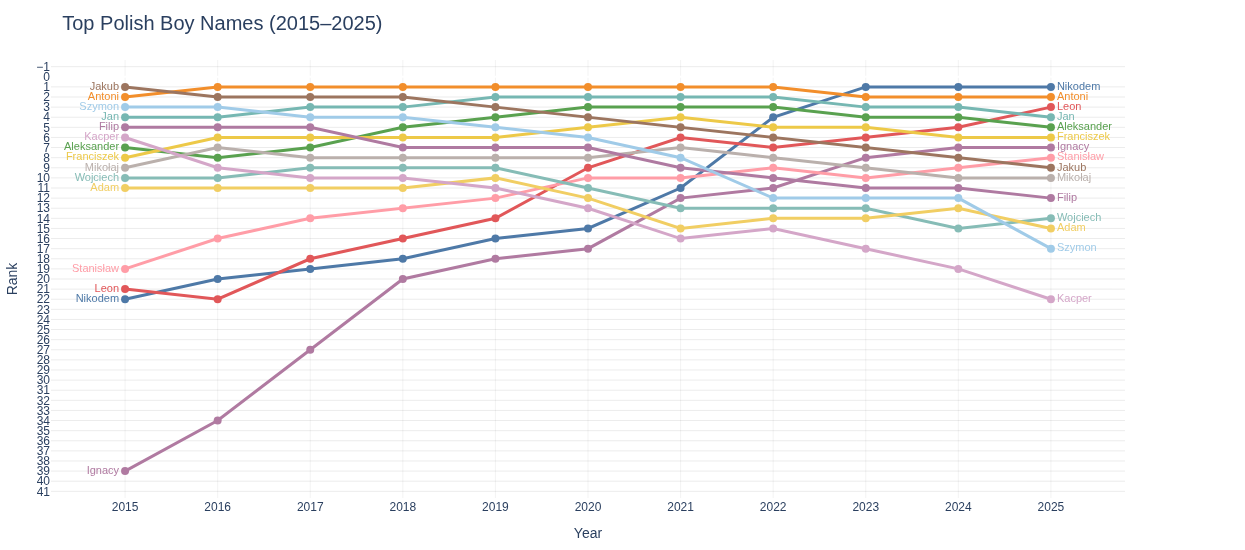

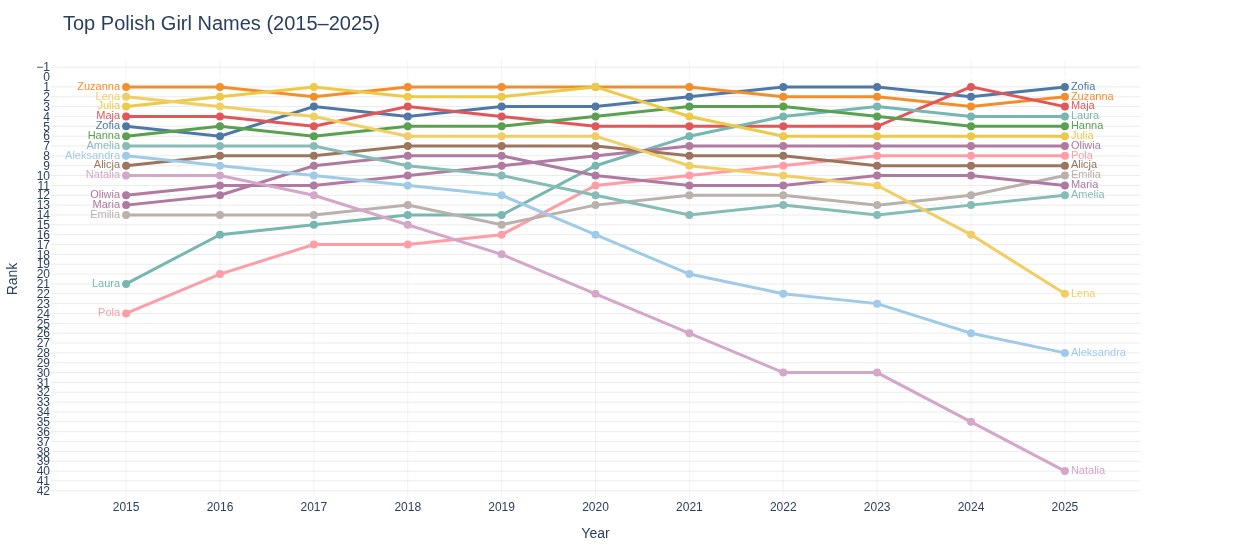

Saved bump charts to reports/


In [13]:
COLORS = [
    "#4e79a7", "#f28e2b", "#e15759", "#76b7b2", "#59a14f",
    "#edc948", "#b07aa1", "#ff9da7", "#9c755f", "#bab0ac",
    "#af7aa1", "#86bcb6", "#f1ce63", "#a0cbe8", "#d4a6c8",
    "#d37295", "#8cd17d", "#b6992d", "#499894", "#fabfd2",
]


def bump_chart(df_bump, sex, title):
    names_df = (
        df_bump.filter(pl.col("sex") == sex)
        .sort("year")
    )
    unique_names = (
        names_df.filter(pl.col("year") == DECADE_END)
        .sort("rank")
        .get_column("name")
        .to_list()
    )
    # Add names that aren't in the final year
    for n in names_df.get_column("name").unique().to_list():
        if n not in unique_names:
            unique_names.append(n)

    fig = go.Figure()

    for i, name in enumerate(unique_names):
        name_data = names_df.filter(pl.col("name") == name).sort("year")
        years = name_data.get_column("year").to_list()
        ranks = name_data.get_column("rank").to_list()
        counts = name_data.get_column("count").to_list()
        color = COLORS[i % len(COLORS)]

        fig.add_trace(go.Scatter(
            x=years, y=ranks,
            mode="lines+markers+text",
            name=name.title(),
            line=dict(color=color, width=3),
            marker=dict(size=8, color=color),
            text=[name.title() if yr in (DECADE_START, DECADE_END) else "" for yr in years],
            textposition=["middle left" if yr == DECADE_START else "middle right" for yr in years],
            textfont=dict(size=11, color=color),
            hovertemplate=f"<b>{name.title()}</b><br>Year: %{{x}}<br>Rank: %{{y}}<br>Count: %{{customdata}}<extra></extra>",
            customdata=counts,
        ))

    fig.update_layout(
        title=dict(text=title, font=dict(size=20)),
        xaxis=dict(
            title="Year", dtick=1, range=[DECADE_START - 0.8, DECADE_END + 0.8],
            gridcolor="rgba(0,0,0,0.05)",
        ),
        yaxis=dict(
            title="Rank", autorange="reversed", dtick=1,
            range=[0.3, TOP_N + 0.7],
            gridcolor="rgba(0,0,0,0.08)",
        ),
        showlegend=False,
        plot_bgcolor="white",
        height=550, width=900,
        margin=dict(l=50, r=120, t=60, b=50),
    )
    return fig


os.makedirs(REPORTS_DIR, exist_ok=True)

fig_male = bump_chart(df_bump, "MALE", "Top Polish Boy Names (2015–2025)")
fig_male.write_html(f"{REPORTS_DIR}/bump_chart_male.html")
fig_male.show()

fig_female = bump_chart(df_bump, "FEMALE", "Top Polish Girl Names (2015–2025)")
fig_female.write_html(f"{REPORTS_DIR}/bump_chart_female.html")
fig_female.show()

print(f"Saved bump charts to {REPORTS_DIR}/")

## Regional Favorites — 2025

Which names dominate in each voivodeship? Fetch the 2025 regional data (names by województwo) and show the top 3 boy and girl names per region.

In [14]:
# Fetch 2025 regional data
# API returns col1=WOJ_code, col2=WOJEWÓDZTWO, col3=IMIĘ, col4=PŁEĆ, col5=LICZBA
# Some rows have empty/null col2 (national totals) — filter those out.

regional_frames = []
for year, resources in REGIONAL_RESOURCES.items():
    for sex_code, rid in resources.items():
        sex_label = "MALE" if sex_code == "M" else "FEMALE"
        csv_path = f"{DATA_DIR}/regional_{year}_{sex_code}.csv"
        if os.path.exists(csv_path):
            print(f"Loading cached {csv_path}")
            df_reg = pl.read_csv(csv_path)
        else:
            print(f"Fetching regional {year} {sex_label} (resource {rid})...")
            rows = fetch_all_pages(rid)
            # Force all-string schema to avoid mixed-type errors (WOJ code is int for some rows, "" for others)
            schema = {k: pl.Utf8 for k in rows[0].keys()}
            df_raw = pl.DataFrame(rows, schema=schema)
            # Map col-based names to semantic names
            df_reg = (
                df_raw
                .filter(pl.col("col2").is_not_null() & (pl.col("col2") != ""))  # drop national totals
                .select(
                    pl.col("col2").alias("voivodeship"),
                    pl.col("col3").alias("name"),
                    pl.col("col5").cast(pl.Int64).alias("count"),
                )
                .with_columns(
                    pl.lit(year).cast(pl.Int32).alias("year"),
                    pl.lit(sex_label).alias("sex"),
                )
            )
            df_reg.write_csv(csv_path)
            print(f"  {len(df_reg)} rows → {csv_path}")
        regional_frames.append(df_reg)

df_regional = pl.concat(regional_frames)
print(f"\nRegional data: {len(df_regional)} rows, {df_regional['voivodeship'].n_unique()} voivodeships")
df_regional.head(5)

Loading cached raw-data/regional_2025_M.csv
Loading cached raw-data/regional_2025_F.csv

Regional data: 7526 rows, 16 voivodeships


voivodeship,name,count,year,sex
str,str,i64,i64,str
"""DOLNOŚLĄSKIE""","""NIKODEM""",415,2025,"""MALE"""
"""DOLNOŚLĄSKIE""","""LEON""",382,2025,"""MALE"""
"""DOLNOŚLĄSKIE""","""ANTONI""",364,2025,"""MALE"""
"""DOLNOŚLĄSKIE""","""FRANCISZEK""",300,2025,"""MALE"""
"""DOLNOŚLĄSKIE""","""JAN""",291,2025,"""MALE"""


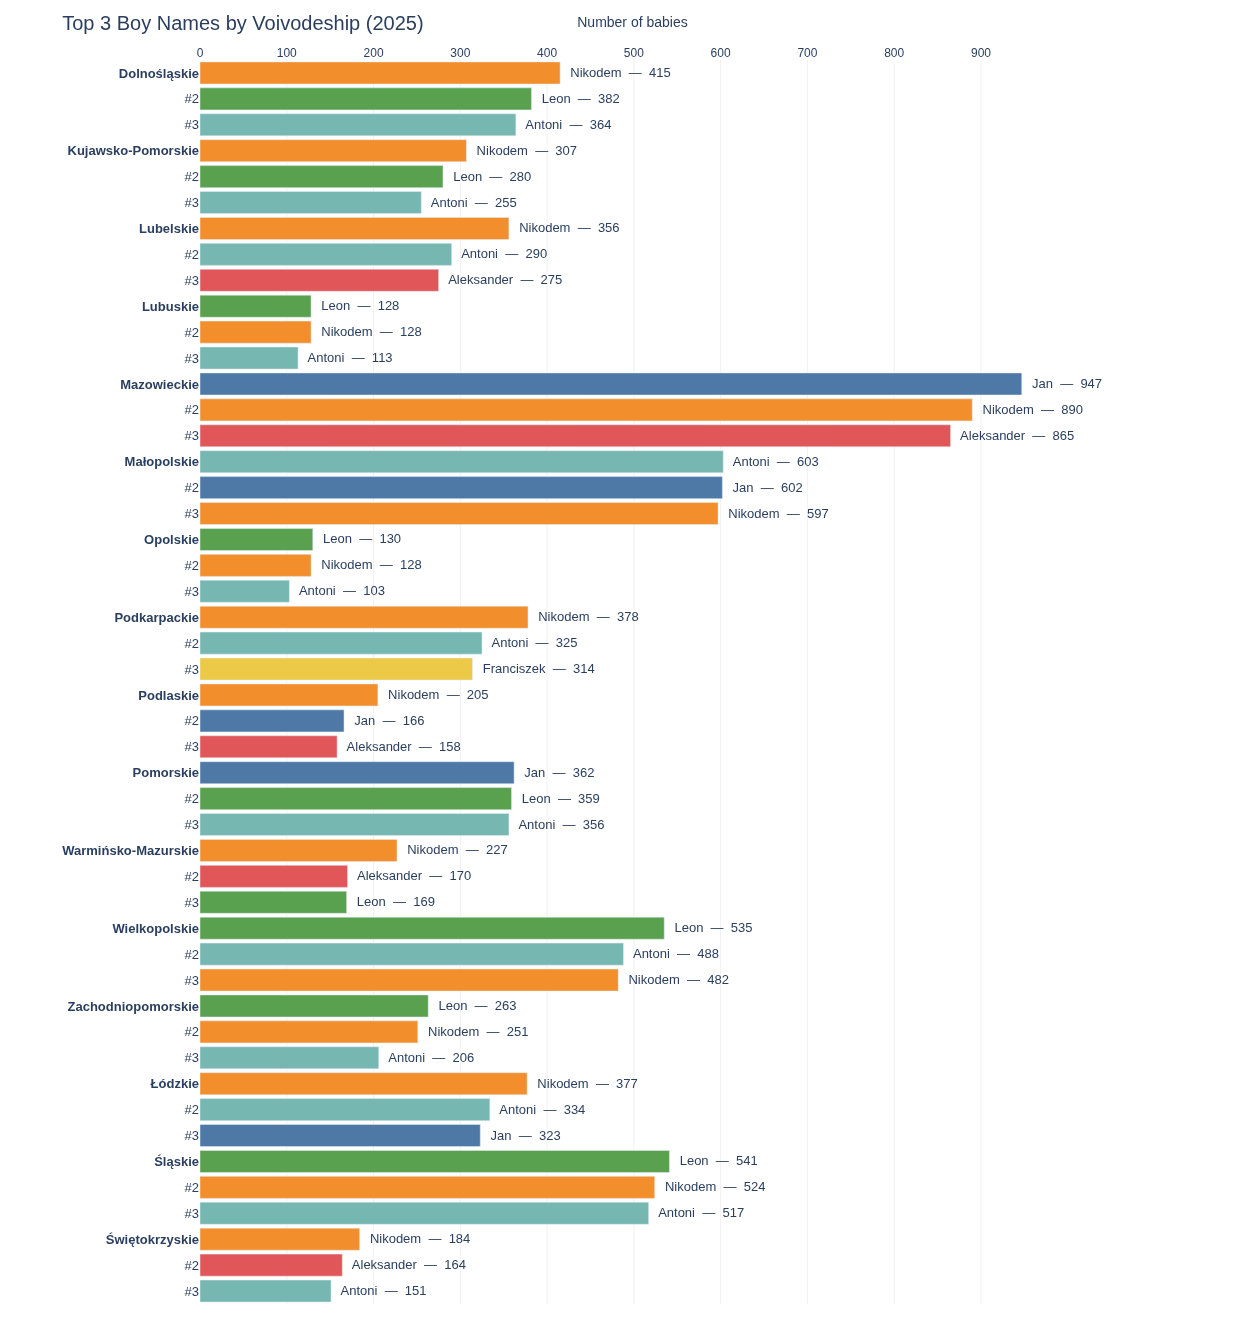

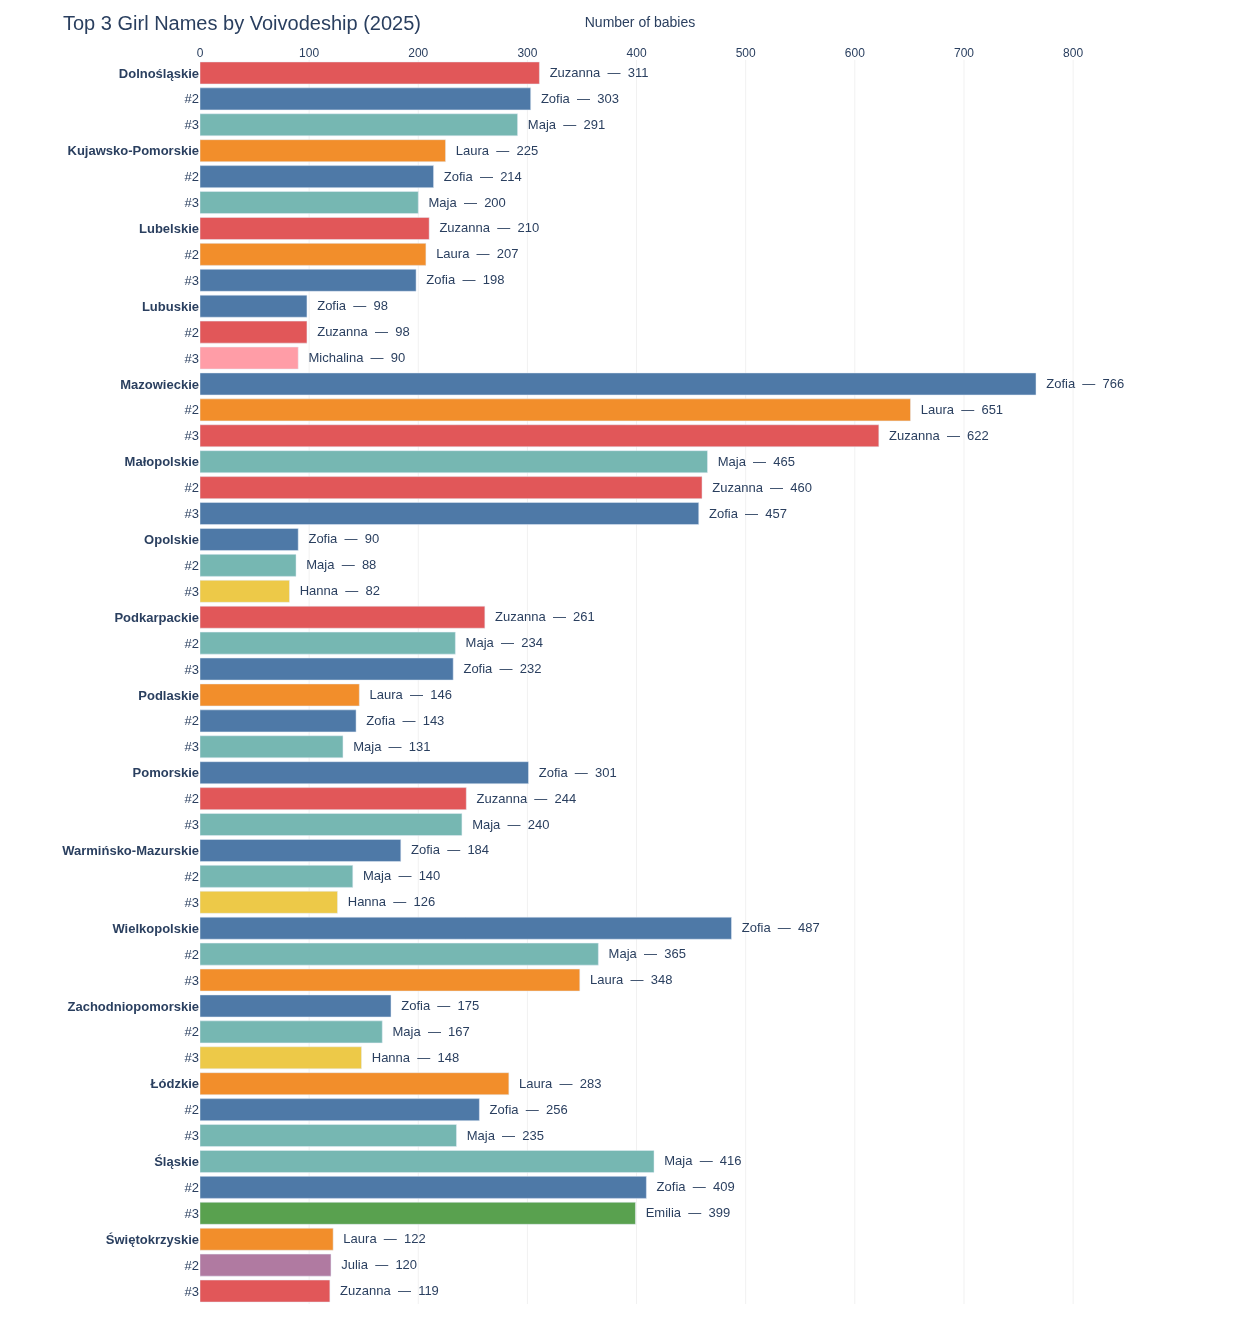

Saved regional charts to reports/


In [17]:
REGIONAL_TOP_N = 3

# Rank names within each voivodeship + sex
df_reg_ranked = (
    df_regional
    .sort("count", descending=True)
    .with_columns(
        pl.col("count")
        .rank(method="ordinal", descending=True)
        .over("voivodeship", "sex")
        .alias("rank")
    )
    .filter(pl.col("rank") <= REGIONAL_TOP_N)
)


def regional_bar_chart(df, sex, title):
    """Horizontal bar chart — one row per voivodeship×rank, name labels outside bars."""
    data = df.filter(pl.col("sex") == sex).sort("voivodeship", "rank")

    all_names = (
        data.sort("count", descending=True)
        .get_column("name").unique(maintain_order=True).to_list()
    )
    name_colors = {n: COLORS[i % len(COLORS)] for i, n in enumerate(all_names)}

    voi_list = data.get_column("voivodeship").to_list()
    names = data.get_column("name").to_list()
    counts = data.get_column("count").to_list()
    ranks = data.get_column("rank").to_list()

    # y-tick labels: voivodeship name for rank 1, indent for ranks 2-3
    y_labels = []
    for v, r in zip(voi_list, ranks):
        if r == 1:
            y_labels.append(f"<b>{v.title()}</b>")
        else:
            y_labels.append(f"   #{r}")

    colors = [name_colors[n] for n in names]
    bar_text = [f"  {n.title()}  —  {c:,}" for n, c in zip(names, counts)]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=list(range(len(y_labels))),
        x=counts,
        orientation="h",
        marker=dict(color=colors),
        text=bar_text,
        textposition="outside",
        textfont=dict(size=13),
        hovertemplate="<b>%{customdata[0]}</b><br>%{customdata[1]} — %{x:,}<extra></extra>",
        customdata=list(zip([v.title() for v in voi_list], [n.title() for n in names])),
        cliponaxis=False,
    ))

    fig.update_layout(
        title=dict(text=title, font=dict(size=20)),
        xaxis=dict(title="Number of babies", side="top", gridcolor="rgba(0,0,0,0.06)"),
        yaxis=dict(
            tickvals=list(range(len(y_labels))),
            ticktext=y_labels,
            autorange="reversed",
            tickfont=dict(size=13),
        ),
        plot_bgcolor="white",
        height=max(700, len(y_labels) * 28),
        width=900,
        margin=dict(l=200, r=180, t=60, b=40),
        showlegend=False,
        bargap=0.15,
    )
    return fig


fig_reg_m = regional_bar_chart(df_reg_ranked, "MALE", "Top 3 Boy Names by Voivodeship (2025)")
fig_reg_m.write_html(f"{REPORTS_DIR}/regional_top3_male_2025.html")
fig_reg_m.show()

fig_reg_f = regional_bar_chart(df_reg_ranked, "FEMALE", "Top 3 Girl Names by Voivodeship (2025)")
fig_reg_f.write_html(f"{REPORTS_DIR}/regional_top3_female_2025.html")
fig_reg_f.show()

print(f"Saved regional charts to {REPORTS_DIR}/")